In [ ]:
#=
using Pkg
Pkg.add("Distributions")
=#

In [1]:
using ModelingToolkit, DifferentialEquations, Random, Distributions, Plots

@parameters C_ATP C_ADP C_cit C_AMP C_PFKM C_AMPK C_Pi C_G6P C_GAP C_DHAP # Concentrations 
@parameters L_PFKM L_PFK2 # L values
@parameters Vf_GPI Vr_GPI Vf_PFK2 Vr_PFK2 Vf_FBP Vr_FBP Vf_ALD Vr_ALD # V values. Vf are Vmax forward and Vr are Vmax reversed for each enzyme.

@parameters Kf_GPI Kr_GPI # For r_GPI
@parameters Ki_ATP Ki_cit Ka_f6p Ka_f16bp Ka_AMP Ka_f26bp # For N_PFKM Ki is inhibitors and Ka is activators
@parameters Kcf_PFKM Kcr_PFKM K_f6p K_ATP K_f16bp K_ADP # For r_PFKM
@parameters K_cat v_P # For psi
@parameters K2_ATP K2_f6p K2_f26bp K2_ADP # For r_PFK2. 2 refers to PFK2
@parameters K_FBP_f26bp K_FBP_f6p K_Pi # For r_FBP
@parameters KAld_f16bp K_GAP K_DHAP # For r_ALD

@variables t f6p(t) f16bp(t) f26bp(t)
D = Differential(t)

r_GPI = (Vf_GPI*C_G6P/Kf_GPI - Vr_GPI*f6p/Kr_GPI)/
    (1 + C_G6P/Kf_GPI + f6p/Kr_GPI)

N_PFKM = 1 + L_PFKM*(1 + C_ATP/Ki_ATP)^4*(1 + C_cit/Ki_cit)^4/
    ((1 + f6p/Ka_f6p + f16bp/Ka_f16bp)^4 * (1 + C_AMP/Ka_AMP)^4 * (1 + f26bp/Ka_f26bp)^4)

r_PFKM = C_PFKM*((Kcf_PFKM*C_ATP*f6p/(K_f6p*K_ATP) - Kcr_PFKM*C_ADP*f16bp/(K_f16bp*K_ADP))/
    ((1 + f6p/K_f6p)*(1 + C_ATP/K_ATP) + (1 + f16bp/K_f16bp)*(1 + C_ADP/K_ADP) -1))*
    (1/N_PFKM)

psi = (K_cat*C_AMPK)/((K_cat*C_AMPK)+v_P)
N_PFK2 = 1 + L_PFK2*(psi/(1-psi))^2

r_PFK2 = ((Vf_PFK2*C_ATP*f6p)/(K2_ATP*K2_f6p) - (Vr_PFK2*C_ADP*f26bp)/(K2_f26bp*K2_ADP)) / 
    ((1+f6p/K2_f6p)*(1+C_ATP/K2_ATP) + (1+f26bp/K2_f26bp)*(1+C_ADP/K2_ADP) -1) *
    (1-(1/N_PFK2))

r_FBP = ((Vf_FBP*f26bp)/(K_FBP_f26bp) - (Vr_FBP*C_Pi*f6p)/(K_Pi*K_FBP_f6p))/
    ((1+f26bp/K_FBP_f26bp) + (1+f6p/K_FBP_f6p)*(1+C_Pi/K_Pi)-1) * 
    (1/N_PFK2)

r_ALD = ((Vf_ALD*f16bp)/(KAld_f16bp) - (Vr_ALD*C_GAP*C_DHAP)/(K_GAP*K_DHAP))/ 
    ((1 + f6p/KAld_f16bp) + (1 + C_GAP/K_GAP)*(1 + C_DHAP/K_DHAP) -1)

eqs = [D(f6p) ~ r_GPI - r_PFKM - r_PFK2 + r_FBP,
    D(f16bp) ~ r_PFKM - r_ALD,
    D(f26bp) ~ r_PFK2 - r_FBP]

@named sys = ODESystem(eqs, t)

sys=structural_simplify(sys)

Model sys with 3 equations
Unknowns (3):
  f6p(t)
  f16bp(t)
  f26bp(t)
Parameters (46):
  Vf_GPI
  K_f16bp
  Ka_f6p
  K_FBP_f6p
⋮
Incidence matrix:3×6 SparseArrays.SparseMatrixCSC{Num, Int64} with 11 stored entries:
 ×  ×  ×  ×  ⋅  ⋅
 ×  ×  ×  ⋅  ×  ⋅
 ×  ⋅  ×  ⋅  ⋅  ×

Cons = [C_ATP => rand(Normal(1.85, 1.85*0.5),1)[], #Biochem
    C_ADP => 0.138, #Biochem
    C_cit => 0.1,
    C_AMP => 3*10^-2, #Mulq
    C_PFKM => 4*10^-5,
    C_AMPK => 6.8275*10^-5, #WT: 5.7875*10^-5 and Zela: 6.8275*10^-5
    C_Pi => 1, #Biochem + Mulq
    C_G6P => 8.3*10^-2, #Biochem
    C_GAP => 1.9*10^-2, #Biochem 
    C_DHAP => 1.38*10^-1, #Biochem
    ]

In [2]:
u0 = [f6p => 1*10^-3,
    f16bp => 1*10^-3,
    f26bp => 1*10^-3]

Cons = [C_ATP => 1.85, #Biochem
    C_ADP => 0.138, #Biochem
    C_cit => 0.1,
    C_AMP => 3*10^-2, #Mulq
    C_PFKM => 4*10^-5,
    C_AMPK => 6.8275*10^-5, #WT: 5.7875*10^-5 and Zela: 6.8275*10^-5
    C_Pi => 1, #Biochem + Mulq
    C_G6P => 8.3*10^-2, #Biochem
    C_GAP => 1.9*10^-2, #Biochem 
    C_DHAP => 1.38*10^-1, #Biochem
    ]
#=
Cons = [C_ATP => 1.85, #Biochem
    C_ADP => 0.138, #Biochem
    C_cit => 0.1,
    C_AMP => 3*10^-2, #Mulq
    C_PFKM => 4*10^-5,
    C_AMPK => 6.8275*10^-5, #WT: 5.7875*10^-5 and Zela: 6.8275*10^-5
    C_Pi => 1, #Biochem + Mulq
    C_G6P => 8.3*10^-2, #Biochem
    C_GAP => 1.9*10^-2, #Biochem 
    C_DHAP => 1.38*10^-1, #Biochem
    ]
=#
L = [L_PFKM => 2*10^-3,
    L_PFK2 => 1*10^-3]

V = [Vf_GPI => 4.8*10^4,
    Vr_GPI => 40*10^4,
    Vf_PFK2 => 41.6,
    Vr_PFK2 => 4, #
    Vf_FBP => 11.78, 
    Vr_FBP => 1.2, #
    Vf_ALD => 6.75*10^2,
    Vr_ALD => 2.32*10^3]

K = [Kf_GPI => 0.3,
    Kr_GPI => 0.123,
    Ki_ATP => 0.1,
    Ki_cit => 0.1, #
    Ka_f6p => 6*10^-2,
    Ka_f16bp => 0.35, #0.35 for PFKM and 0.65 for PFKL
    Ka_AMP => 0.3,
    Ka_f26bp => 5.5*10^-3,
    Kcf_PFKM => 15.5*10^2/4*10^-5, #
    Kcr_PFKM => 6.78*10^1/4*10^-5, #
    K_f6p => 6*10^-2,
    K_ATP => 6.8*10^-2,
    K_f16bp => 0.65,
    K_ADP => 0.54,
    K_cat => 0.1,
    v_P => 0.005,
    K2_ATP => 0.15,
    K2_f6p => 0.032,
    K2_f26bp => 0.008,
    K2_ADP => 0.062,
    K_FBP_f26bp => 1*10^-3,
    K_FBP_f6p => 25*10^-3,
    K_Pi => 0.23, #
    KAld_f16bp => 5*10^-2,
    K_GAP => 0.189,
    K_DHAP => 3.5*10^-2] 

p= [Cons 
    L 
    V 
    K]


46-element Vector{Pair{Num, Float64}}:
       C_ATP => 1.85
       C_ADP => 0.138
       C_cit => 0.1
       C_AMP => 0.030000000000000006
      C_PFKM => 4.0e-5
      C_AMPK => 6.8275e-5
        C_Pi => 1.0
       C_G6P => 0.08300000000000002
       C_GAP => 0.019000000000000003
      C_DHAP => 0.13799999999999998
             ⋮
      K2_f6p => 0.032
    K2_f26bp => 0.008
      K2_ADP => 0.062
 K_FBP_f26bp => 0.001
   K_FBP_f6p => 0.025
        K_Pi => 0.23
  KAld_f16bp => 0.05000000000000001
       K_GAP => 0.189
      K_DHAP => 0.035

[0.0040836, 0.06811724195851505, 7.234546770814855e-5]

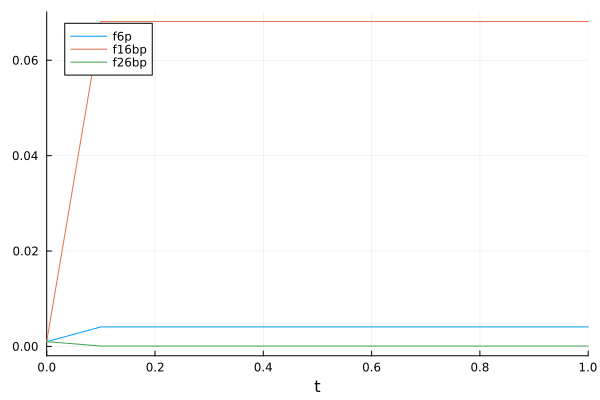

In [3]:
tspan = (0.0, 100)
prob = ODEProblem(sys, u0, tspan, p, jac = true)
sol = solve(prob)
print(sol[end])
# WT: [0.004083592505316987, 0.06812485220772822, 0.0005326425014835493]
# Ze: [0.004083592505316986, 0.06812485220772978, 0.0005326425017929931]

plot(sol,
    xlim = (0.000, 1))


In [12]:
#=
flux_01 = zeros(length(p))
for i in length(p)
    flux_01[i] = p[i][2]
end
=#
function flux_vector(u, p_flux)
    flux_01 = zeros(length(p_flux))
    for i in 1:length(p_flux)
        flux_01[i] = p_flux[i][2]
    end
    u_01 = zeros(length(u))
    for i in 1:length(u)
        u_01[i] = u[i][2]
    end
    
    C_ATP, C_ADP, C_cit, C_AMP, C_PFKM, C_AMPK, C_Pi, C_G6P, C_GAP, C_DHAP, L_PFKM, L_PFK2, Vf_GPI, Vr_GPI, Vf_PFK2, Vr_PFK2, Vf_FBP, Vr_FBP, Vf_ALD, Vr_ALD, Kf_GPI, Kr_GPI, Ki_ATP, Ki_cit, Ka_f6p, Ka_f16bp, Ka_AMP, Ka_f26bp, Kcf_PFKM, Kcr_PFKM, K_f6p, K_ATP, K_f16bp, K_ADP, K_cat, v_P, K2_ATP, K2_f6p, K2_f26bp, K2_ADP, K_FBP_f26bp, K_FBP_f6p, K_Pi, KAld_f16bp, K_GAP, K_DHAP = flux_01
    f6p, f16bp, f26bp = u_01

    r_GPI = (Vf_GPI*C_G6P/Kf_GPI - Vr_GPI*f6p/Kr_GPI)/(1 + C_G6P/Kf_GPI + f6p/Kr_GPI)

    N_PFKM = 1 + L_PFKM*(1 + C_ATP/Ki_ATP)^4*(1 + C_cit/Ki_cit)^4/
        ((1 + f6p/Ka_f6p + f16bp/Ka_f16bp)^4 * (1 + C_AMP/Ka_AMP)^4 * (1 + f26bp/Ka_f26bp)^4)

    r_PFKM = C_PFKM*((Kcf_PFKM*C_ATP*f6p/(K_f6p*K_ATP) - Kcr_PFKM*C_ADP*f16bp/(K_f16bp*K_ADP))/
        ((1 + f6p/K_f6p)*(1 + C_ATP/K_ATP) + (1 + f16bp/K_f16bp)*(1 + C_ADP/K_ADP) -1))*
        (1/N_PFKM)

    psi = (K_cat*C_AMPK)/((K_cat*C_AMPK)+v_P)
    N_PFK2 = 1 + L_PFK2*(psi/(1-psi))^2

    r_PFK2 = ((Vf_PFK2*C_ATP*f6p)/(K2_ATP*K2_f6p) - (Vr_PFK2*C_ADP*f26bp)/(K2_f26bp*K2_ADP)) / 
        ((1+f6p/K2_f6p)*(1+C_ATP/K2_ATP) + (1+f26bp/K2_f26bp)*(1+C_ADP/K2_ADP) -1) *
        (1-(1/N_PFK2))

    r_FBP = ((Vf_FBP*f26bp)/(K_FBP_f26bp) - (Vr_FBP*C_Pi*f6p)/(K_Pi*K_FBP_f6p))/
        ((1+f26bp/K_FBP_f26bp) + (1+f6p/K_FBP_f6p)*(1+C_Pi/K_Pi)-1) * 
        (1/N_PFK2)

    r_ALD = ((Vf_ALD*f16bp)/(KAld_f16bp) - (Vr_ALD*C_GAP*C_DHAP)/(K_GAP*K_DHAP))/ 
        ((1 + f6p/KAld_f16bp) + (1 + C_GAP/K_GAP)*(1 + C_DHAP/K_DHAP) -1)

    return[r_GPI, r_PFKM, r_PFK2, r_FBP, r_ALD
    ]
end 
flux_vector(u0, p)



5-element Vector{Float64}:
 7805.1002974118865
    1.618867252602088e-12
    1.6985428818214422e-9
    1.763450831591293
 -165.9565763934844

In [ ]:

for i in 1:length(u0)
    u_01[i] = u[i][2]
end

In [13]:
function SimData(odeSys, u0, Cons, L, V, K, tspan)
    p = [Cons 
        L 
        V 
        K]
    prob = ODEProblem(sys, u0, tspan, p, jac = true)
    sol = solve(prob)

    flux_ss = flux_vector(u0, p)
    return sol[end]
end

f6p_ss, f16bp_ss, f26bp_ss = SimData(sys, u0, Cons, L, V, K, (0.0,100))


3-element Vector{Float64}:
 0.0040836
 0.06811724195851505
 7.234546770814855e-5

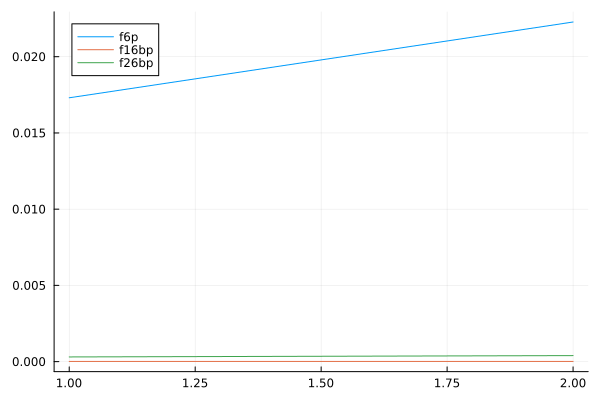

In [70]:
n_sim = 2
u0 = [f6p => 1*10^-1,
    f16bp => 1*10^-1,
    f26bp => 1*10^-1]

f6p_ss_vec = zeros(n_sim);
f16bp_ss_vec = zeros(n_sim);
f26bp_ss_vec = zeros(n_sim);
flux_ss = zeros(5,n_sim);
seed_vec = [1231, 1232, 1233, 1234, 1235, 1236, 1237, 1238, 1239, 1230];

for i in 1:n_sim
    Random.seed!(seed_vec[i])
    Cons = [C_ATP => rand(LogNormal(-5.643, 0.166),1)[]*1000, #M to mM
        C_ADP => rand(LogNormal(-6.616, 0.169),1)[]*1000, 
        C_cit => rand(LogNormal(-3.930, 0.225),1)[]*1000,
        C_AMP => rand(LogNormal(-12.151, 0.274),1)[]*1000,
        C_PFKM => 4*10^-5,
        C_AMPK => 5.7875*10^-5, #WT: 5.7875*10^-5 and Zela: 6.8275*10^-5
        C_Pi => 1, 
        C_G6P => rand(LogNormal(-7.762, 0.314),1)[]*1000, 
        C_GAP => rand(LogNormal(-15.059, 0.165),1)[]*1000, 
        C_DHAP => rand(LogNormal(-13.059, 0.165),1)[]*1000, 
    ]
    f6p_ss_vec[i], f16bp_ss_vec[i], f26bp_ss_vec[i] = SimData(sys, u0, Cons, L, V, K, (0.0,100))
    p = [Cons
        L
        V
        K]
    flux_ss[:,i] = flux_vector([f6p_ss_vec[i],f16bp_ss_vec[i],f26bp_ss_vec[i]],p)
       
end

#print(f6p)
plot([1:n_sim],[f6p_ss_vec,f16bp_ss_vec,f26bp_ss_vec],label=["f6p" "f16bp" "f26bp"])


In [72]:
print(flux_ss[:,1])
0.13 #mmol mLcell^-1 h^-1
0.13*1000 # mmol Lcell^-1 h^-1

[-3.1454339389598115e-12, 7.275582061515429e-21, 1.2591523371601951e-8, 1.2591523136239793e-8, -3.9690572980658884e-17]

130.0

In [14]:
Cons = [C_ATP => rand(LogNormal(-5.643, 0.166),1)[]*1000, #M to mM
C_ADP => rand(LogNormal(-6.616, 0.169),1)[]*1000, 
C_cit => rand(LogNormal(-3.930, 0.225),1)[]*1000,
C_AMP => rand(LogNormal(-12.151, 0.274),1)[]*1000,
C_PFKM => 4*10^-5,
C_AMPK => 5.7875*10^-5, #WT: 5.7875*10^-5 and Zela: 6.8275*10^-5
C_Pi => 1, 
C_G6P => rand(LogNormal(-7.762, 0.314),1)[]*1000, 
C_GAP => rand(LogNormal(-15.059, 0.165),1)[]*1000, 
C_DHAP => rand(LogNormal(-13.059, 0.165),1)[]*1000, 
]


10-element Vector{Pair{Num, Float64}}:
  C_ATP => 3.190221251657431
  C_ADP => 1.2626168630118335
  C_cit => 20.346371732264547
  C_AMP => 0.005262370529490401
 C_PFKM => 4.0e-5
 C_AMPK => 5.7875000000000004e-5
   C_Pi => 1.0
  C_G6P => 0.4429552105766702
  C_GAP => 0.0002722149620825047
 C_DHAP => 0.0024320309651530083

In [15]:
p = [Cons 
L 
V 
K]

prob = ODEProblem(sys, u0, tspan, p, jac = true)
sol = solve(prob)
print(sol)

ODESolution{Float64, 2, Vector{Vector{Float64}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{Vector{Float64}}}, ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, ModelingToolkit.MTKParameters{Tuple{Vector{Float64}}, Tuple{}, Tuple{}, Tuple{}, Tuple{}, Nothing, Nothing}, ODEFunction{true, SciMLBase.AutoSpecialize, ModelingToolkit.var"#f#683"{RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋arg1, :ˍ₋arg2, :t), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xccfb0d24, 0x627a5f99, 0xf457246b, 0x31945274, 0x9c05d2dd), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :ˍ₋arg1, :ˍ₋arg2, :t), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xeed47946, 0x4b5fc095, 0xc42aada5, 0x5f4bf664, 0xd9c08b73), Nothing}}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, ModelingToolkit.var"#_jac#688"{RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋arg1, :ˍ₋arg2, :t), ModelingToolkit.var"#_RGF_ModTag", Model